# Problem 1: Multi-Taxi Routing with Capacity-Constrained Roads

We are given a city represented as a weighted undirected graph where:
- Multiple taxis must pick up and drop off passengers (1 taxi per passenger).
- Each edge has a distance and corresponds to a travel time at constant speed.
- At most 2 taxis can use the same edge simultaneously; a third must wait **30 minutes** before entering.

The objective is to plan routes so that all passengers are transported while **minimizing the overall completion time** (makespan).

---

## Approach & Heuristic

We solve this using **A\* search** for each taxi’s route, while simulating congestion events.

- **Precomputation**: Run **Dijkstra’s algorithm** from each destination node to compute exact shortest travel-times (in minutes).  
- **Heuristic \(h(n)\)**: For any node \(n\), use the Dijkstra-computed travel-time to the goal.  
- **Evaluation function**:  
  \[
  f(n) = g(n) + h(n)
  \]  
  where  
  • \(g(n)\) = elapsed time so far (including wait penalties for congestion),  
  • \(h(n)\) = admissible shortest-time-to-goal from Dijkstra.

This heuristic is **admissible** because it never overestimates the true remaining cost, ensuring that A\* finds optimal routes under the travel-time and congestion rules.


In [3]:
from math import sqrt
import heapq
from typing import Dict, List, Tuple

sample_input = """8 9 3 30 40
0 0
30 0
80 0
30 60
120 0
30 120
60 120
110 120
1 2 30
2 3 50
2 4 60
3 5 40
4 6 70
5 7 20
6 7 30
7 8 50
3 6 90
2 7
1 8
3 4
"""

def parse_input(text: str):
    tokens = text.strip().split()
    it = iter(tokens)
    N = int(next(it)); M = int(next(it)); P = int(next(it))
    W = int(next(it))  # minutes
    S = float(next(it))  # km/h
    coords = {}
    for i in range(1, N+1):
        x = float(next(it)); y = float(next(it))
        coords[i] = (x,y)
    graph = {i:[] for i in range(1, N+1)}
    for _ in range(M):
        u = int(next(it)); v = int(next(it)); d = float(next(it))
        graph[u].append((v,d)); graph[v].append((u,d))
    trips = []
    for _ in range(P):
        a = int(next(it)); b = int(next(it))
        trips.append((a,b))
    return N, M, P, W, S, coords, graph, trips

def dijkstra_all_sources(goal:int, graph:Dict[int,List[Tuple[int,float]]], time_per_km:float):
    # Dijkstra from goal to all nodes (because graph is undirected, same as to-go)
    heap = []
    heapq.heappush(heap, (0.0, goal))
    dist_map = {goal: 0.0}
    while heap:
        g, node = heapq.heappop(heap)
        if g > dist_map.get(node, float('inf')) + 1e-9:
            continue
        for neigh, d in graph[node]:
            travel = d * time_per_km
            tentative = g + travel
            if tentative + 1e-9 < dist_map.get(neigh, float('inf')):
                dist_map[neigh] = tentative
                heapq.heappush(heap, (tentative, neigh))
    return dist_map  # dist_map[n] = min minutes from n -> goal

def a_star_with_precomputed_heuristic(start:int, goal:int, graph:Dict[int,List[Tuple[int,float]]],
                                      time_per_km:float, h:Dict[int,float]):
    # A* using precomputed exact heuristic h (h[node] = shortest time from node to goal)
    open_heap = []
    g_scores = {start: 0.0}
    f0 = g_scores[start] + h.get(start, float('inf'))
    heapq.heappush(open_heap, (f0, 0.0, start, [start]))
    while open_heap:
        f, g, node, path = heapq.heappop(open_heap)
        if g > g_scores.get(node, float('inf')) + 1e-9:
            continue
        if node == goal:
            return path, g
        for neigh, d in graph[node]:
            travel = d * time_per_km
            tentative_g = g + travel
            if tentative_g + 1e-9 < g_scores.get(neigh, float('inf')):
                g_scores[neigh] = tentative_g
                heapq.heappush(open_heap, (tentative_g + h.get(neigh, float('inf')), tentative_g, neigh, path + [neigh]))
    return None, float('inf')

def count_overlaps(reservations:List[Tuple[float,float]], start:float, end:float):
    cnt = 0
    for (a,b) in reservations:
        if not (end <= a or start >= b):
            cnt += 1
    return cnt

def plan_and_simulate_with_precompute(N, M, P, W, S, coords, graph, trips):
    time_per_km = 60.0 / S  # minutes per km
    # Precompute heuristics for each distinct destination
    unique_goals = sorted(set(dst for (_,dst) in trips))
    heuristics = {}  # goal -> dict[node] = time_minutes
    for g in unique_goals:
        heuristics[g] = dijkstra_all_sources(g, graph, time_per_km)
    # Use A* with precomputed heuristic for each taxi to get path
    paths = []
    for (src,dst) in trips:
        h = heuristics[dst]
        path, total_min = a_star_with_precomputed_heuristic(src, dst, graph, time_per_km, h)
        if path is None:
            raise RuntimeError(f"No path found from {src} to {dst}")
        paths.append(path)
    # reservations per undirected edge
    reservations: Dict[Tuple[int,int], List[Tuple[float,float]]] = {}
    for u in range(1, N+1):
        for v, _ in graph[u]:
            key = tuple(sorted((u,v)))
            reservations.setdefault(key, [])
    # event-driven simulation (all taxis start at 0)
    taxis_state = []
    pq = []
    for i, path in enumerate(paths):
        state = {'path': path, 'idx': 0, 'time': 0.0, 'finished': False, 'events': []}
        taxis_state.append(state)
        heapq.heappush(pq, (0.0, i))
    while pq:
        current_time, taxi_i = heapq.heappop(pq)
        state = taxis_state[taxi_i]
        if abs(current_time - state['time']) > 1e-6 and current_time > state['time'] + 1e-9:
            continue
        if state['finished']:
            continue
        path = state['path']; idx = state['idx']
        if idx >= len(path)-1:
            state['finished'] = True
            continue
        u = path[idx]; v = path[idx+1]
        dist = next(d for (nb,d) in graph[u] if nb == v)
        edge_time = dist * time_per_km
        start = state['time']; end = start + edge_time
        edge_key = tuple(sorted((u,v)))
        overlaps = count_overlaps(reservations[edge_key], start, end)
        if overlaps <= 1:
            reservations[edge_key].append((start,end))
            state['events'].append(('edge', (u,v,start,end)))
            state['time'] = end
            state['idx'] += 1
            if state['idx'] < len(path)-1:
                heapq.heappush(pq, (state['time'], taxi_i))
            else:
                state['finished'] = True
        else:
            state['events'].append(('wait', (u, start, start+W)))
            state['time'] = start + W
            heapq.heappush(pq, (state['time'], taxi_i))
    taxi_details = []
    taxi_finish_times = []
    for i, state in enumerate(taxis_state, start=1):
        total_time = state['time']
        taxi_finish_times.append(total_time)
        taxi_details.append({
            'taxi': i,
            'trip': trips[i-1],
            'path': state['path'],
            'events': state['events'],
            'total_time': total_time
        })
    total_completion_time = sum(taxi_finish_times)
    makespan = max(taxi_finish_times) if taxi_finish_times else 0.0
    return taxi_details, total_completion_time, makespan, heuristics

# Run with sample input and print results
N, M, P, W, S, coords, graph, trips = parse_input(sample_input)
taxi_details, total_completion_time, makespan, heuristics = plan_and_simulate_with_precompute(N, M, P, W, S, coords, graph, trips)

def pretty_print_results(taxi_details, total_completion_time, makespan):
    for td in taxi_details:
        print(f"Taxi {td['taxi']}:")
        a,b = td["trip"]
        print(f"Passenger {a}->{b}")
        route_str = " -> ".join(str(x) for x in td["path"])
        print(f"Route: {route_str}")
        for ev in td["events"]:
            if ev[0] == "wait":
                node, s, e = ev[1]
                path = td["path"]
                idx = None
                for i in range(len(path)-1):
                    if path[i] == node:
                        idx = i; break
                if idx is not None:
                    u = path[idx]; v = path[idx+1]
                    print(f"WAIT on edge ({u}->{v}): {int(e-s)} minutes")
        print(f"Total time = {td['total_time']:.1f} minutes\n")
    print(f"Total Completion Time = {total_completion_time:.1f} minutes")
    print(f"Makespan = {makespan:.1f} minutes\n")

pretty_print_results(taxi_details, total_completion_time, makespan)



Taxi 1:
Passenger 2->7
Route: 2 -> 3 -> 5 -> 7
Total time = 165.0 minutes

Taxi 2:
Passenger 1->8
Route: 1 -> 2 -> 3 -> 5 -> 7 -> 8
WAIT on edge (2->3): 30 minutes
Total time = 315.0 minutes

Taxi 3:
Passenger 3->4
Route: 3 -> 2 -> 4
Total time = 165.0 minutes

Total Completion Time = 645.0 minutes
Makespan = 315.0 minutes



# Problem 3: The Game of Tic-Tac-Toe

Initial board (X to move):
```
__ | X  | __
O  | __ | __
X  | __ | O
```

## Evaluation Function

$$
\text{Eval}(s) = 8X_3 + 3X_2 + X_1 - (8O_3 + 3O_2 + O_1)
$$

Where:
- $X_3, X_2, X_1$ = Number of 3-in-a-row, 2-in-a-row, and 1-in-a-row for X
- $O_3, O_2, O_1$ = Number of 3-in-a-row, 2-in-a-row, and 1-in-a-row for O

---

## Approach

- Build the game tree until terminal states.
- Apply **Minimax**: X = MAX, O = MIN.
- Use **Alpha-Beta pruning** to reduce explored nodes.

---

## Results

**Possible first moves:** (1,1), (1,3), (2,2), (2,3), (3,2)

**Minimax values:**
- (1,1) → 0
- (1,3) → 5
- (2,2) → 5
- (2,3) → 0
- (3,2) → -8

**Best value = 5** → Optimal moves: (1,3) or (2,2)

**Nodes expanded:**
- Minimax = 226
- Alpha-Beta = 98 (≈57% fewer)

In [9]:
from copy import deepcopy

INITIAL_BOARD = [
    [None, 'X',   None],
    ['O',  None,  None],
    ['X',  None,  'O']
]

LINES = [
    # rows
    [(0,0),(0,1),(0,2)],
    [(1,0),(1,1),(1,2)],
    [(2,0),(2,1),(2,2)],
    # cols
    [(0,0),(1,0),(2,0)],
    [(0,1),(1,1),(2,1)],
    [(0,2),(1,2),(2,2)],
    # diags
    [(0,0),(1,1),(2,2)],
    [(0,2),(1,1),(2,0)],
]

def print_board(b):
    for r in b:
        print("|".join([(c if c is not None else "__") for c in r]))
    print()

def get_legal_moves(board):
    return [(r,c) for r in range(3) for c in range(3) if board[r][c] is None]

def apply_move(board, move, player):
    b2 = deepcopy(board)
    r,c = move
    b2[r][c] = player
    return b2

def winner(board):
    # return 'X' or 'O' or None
    for line in LINES:
        values = [board[r][c] for r,c in line]
        if values[0] is not None and values.count(values[0]) == 3:
            return values[0]
    return None

def is_terminal(board):
    if winner(board) is not None:
        return True
    if all(board[r][c] is not None for r in range(3) for c in range(3)):
        return True
    return False

def evaluation(board):
    # Evaluation(s) = 8*X3 + 3*X2 + X1  – (8*O3 + 3*O2 + O1)
    X3 = X2 = X1 = 0
    O3 = O2 = O1 = 0
    for line in LINES:
        vals = [board[r][c] for r,c in line]
        xcount = vals.count('X')
        ocount = vals.count('O')
        # ignore empty-only lines
        if ocount == 0 and xcount > 0:
            if xcount == 3:
                X3 += 1
            elif xcount == 2:
                X2 += 1
            elif xcount == 1:
                X1 += 1
        if xcount == 0 and ocount > 0:
            if ocount == 3:
                O3 += 1
            elif ocount == 2:
                O2 += 1
            elif ocount == 1:
                O1 += 1
    val = 8*X3 + 3*X2 + X1 - (8*O3 + 3*O2 + O1)
    return val

# --- Minimax (full expansion to terminals) ---
def minimax(board, player, stats):
    """
    stats is a dict to accumulate nodes visited: stats['nodes'] incremented on each call.
    Returns value (int).
    """
    stats['nodes'] += 1
    if is_terminal(board):
        return evaluation(board)
    if player == 'X':  # MAX
        best = float('-inf')
        for mv in get_legal_moves(board):
            val = minimax(apply_move(board, mv, 'X'), 'O', stats)
            if val > best:
                best = val
        return best
    else:  # MIN (O)
        best = float('inf')
        for mv in get_legal_moves(board):
            val = minimax(apply_move(board, mv, 'O'), 'X', stats)
            if val < best:
                best = val
        return best

# --- Alpha-Beta (full search with pruning) ---
def alphabeta(board, player, alpha, beta, stats):
    """
    stats is a dict with 'nodes' and 'prunes' counters.
    Returns value (int).
    """
    stats['nodes'] += 1
    if is_terminal(board):
        return evaluation(board)
    if player == 'X':
        value = float('-inf')
        for mv in get_legal_moves(board):
            value = max(value, alphabeta(apply_move(board, mv, 'X'), 'O', alpha, beta, stats))
            alpha = max(alpha, value)
            if alpha >= beta:
                stats['prunes'] += 1
                break  # beta cut-off
        return value
    else:
        value = float('inf')
        for mv in get_legal_moves(board):
            value = min(value, alphabeta(apply_move(board, mv, 'O'), 'X', alpha, beta, stats))
            beta = min(beta, value)
            if alpha >= beta:
                stats['prunes'] += 1
                break  # alpha cut-off
        return value

# Helper to compute minimax values for each first move
def evaluate_first_moves_minimax(board):
    moves = get_legal_moves(board)
    results = []
    for mv in moves:
        newb = apply_move(board, mv, 'X')
        stats = {'nodes': 0}
        val = minimax(newb, 'O', stats)
        results.append((mv, val, stats['nodes']))
    return results

# Helper to compute minimax values for each first move but using alphabeta (for comparison)
def evaluate_first_moves_alphabeta(board):
    moves = get_legal_moves(board)
    results = []
    for mv in moves:
        newb = apply_move(board, mv, 'X')
        stats = {'nodes': 0, 'prunes': 0}
        val = alphabeta(newb, 'O', float('-inf'), float('inf'), stats)
        results.append((mv, val, stats['nodes'], stats['prunes']))
    return results

# Run full minimax from the root with bookkeeping to also find the best move and count nodes:
def minimax_root(board):
    moves = get_legal_moves(board)
    best_val = float('-inf')
    best_moves = []
    total_nodes = 0
    per_move = []
    for mv in moves:
        newb = apply_move(board, mv, 'X')
        stats = {'nodes': 0}
        val = minimax(newb, 'O', stats)
        total_nodes += stats['nodes']
        per_move.append((mv, val, stats['nodes']))
        if val > best_val:
            best_val = val
            best_moves = [mv]
        elif val == best_val:
            best_moves.append(mv)
    return best_val, best_moves, per_move, total_nodes

# Run alpha-beta root-level search to find best move with pruning & counts
def alphabeta_root(board):
    moves = get_legal_moves(board)
    best_val = float('-inf')
    best_moves = []
    total_nodes = 0
    total_prunes = 0
    per_move = []
    # we'll evaluate each first move using alphabeta on the resulting board,
    # this also gives a sense of per-first-move nodes & prunes
    for mv in moves:
        newb = apply_move(board, mv, 'X')
        stats = {'nodes': 0, 'prunes': 0}
        val = alphabeta(newb, 'O', float('-inf'), float('inf'), stats)
        per_move.append((mv, val, stats['nodes'], stats['prunes']))
        total_nodes += stats['nodes']
        total_prunes += stats['prunes']
        if val > best_val:
            best_val = val
            best_moves = [mv]
        elif val == best_val:
            best_moves.append(mv)
    return best_val, best_moves, per_move, total_nodes, total_prunes

# --- Main execution and printing ---
if __name__ == "__main__":
    print("Initial board:")
    print_board(INITIAL_BOARD)

    # Minimax: evaluate every first move (X moves now)
    best_val_m, best_moves_m, per_move_m, total_nodes_m = minimax_root(INITIAL_BOARD)
    print("MINIMAX (full expansion) results:")
    for mv, val, nodes in per_move_m:
        print(f" Move {mv} (1-based: {(mv[0]+1,mv[1]+1)}) -> Minimax value = {val}, nodes expanded for this subtree = {nodes}")
    print(f" Best minimax value = {best_val_m}")
    print(" Best first-move(s):", [ (mv, (mv[0]+1,mv[1]+1)) for mv in best_moves_m ])
    print(f" Total nodes visited by full minimax (sum of subtree nodes) = {total_nodes_m}")
    print()

    # Alpha-Beta: evaluate every first move using alphabeta (to get per-move nodes/prunes)
    best_val_ab, best_moves_ab, per_move_ab, total_nodes_ab, total_prunes_ab = alphabeta_root(INITIAL_BOARD)
    print("ALPHA-BETA results (per-first-move alphabeta on resulting board):")
    for mv, val, nodes, prunes in per_move_ab:
        print(f" Move {mv} (1-based: {(mv[0]+1,mv[1]+1)}) -> AlphaBeta value = {val}, nodes = {nodes}, prunes = {prunes}")
    print(f" Best alpha-beta value = {best_val_ab}")
    print(" Best first-move(s):", [ (mv, (mv[0]+1,mv[1]+1)) for mv in best_moves_ab ])
    print(f" Total nodes visited by alpha-beta (sum of subtree nodes) = {total_nodes_ab}")
    print(f" Total prunes encountered across subtrees = {total_prunes_ab}")
    print()

    # For completeness: show the evaluation on the terminal states if we make one of the best moves
    print("Example: apply one optimal move and show some resulting board(s) and their evaluations.")
    example_mv = best_moves_m[0]
    b_after = apply_move(INITIAL_BOARD, example_mv, 'X')
    print(" After optimal move", example_mv, "(1-based:", (example_mv[0]+1, example_mv[1]+1), ")")
    print_board(b_after)
    # If this new board is terminal, show its evaluation; otherwise, show evaluation when it's finally terminal
    print("Evaluation of this board (by the heuristic):", evaluation(b_after))


Initial board:
__|X|__
O|__|__
X|__|O

MINIMAX (full expansion) results:
 Move (0, 0) (1-based: (1, 1)) -> Minimax value = 0, nodes expanded for this subtree = 47
 Move (0, 2) (1-based: (1, 3)) -> Minimax value = 5, nodes expanded for this subtree = 35
 Move (1, 1) (1-based: (2, 2)) -> Minimax value = 5, nodes expanded for this subtree = 39
 Move (1, 2) (1-based: (2, 3)) -> Minimax value = 0, nodes expanded for this subtree = 61
 Move (2, 1) (1-based: (3, 2)) -> Minimax value = -8, nodes expanded for this subtree = 43
 Best minimax value = 5
 Best first-move(s): [((0, 2), (1, 3)), ((1, 1), (2, 2))]
 Total nodes visited by full minimax (sum of subtree nodes) = 225

ALPHA-BETA results (per-first-move alphabeta on resulting board):
 Move (0, 0) (1-based: (1, 1)) -> AlphaBeta value = 0, nodes = 20, prunes = 6
 Move (0, 2) (1-based: (1, 3)) -> AlphaBeta value = 5, nodes = 17, prunes = 6
 Move (1, 1) (1-based: (2, 2)) -> AlphaBeta value = 5, nodes = 31, prunes = 6
 Move (1, 2) (1-based: (2, 

# Problem 4: Chip Placement Optimization using Integer Descent

We are given a grid $G$ of size $W \times H$. A set of tall rectangular chips must be placed:
- Each chip $c_i$ has width $w_i$, height $h_i$ with $h_i > w_i$.
- Each chip is **locked** to a fixed row $y_i$.
- Chips can only move **horizontally by integer steps**.

Additionally, some chips are connected through a **netlist**.

The objective is to arrange chips on the grid to **minimize the conflict score**.

---

## Conflict Score

$$
\text{Conflict}(P) = \sum_{(c_i,c_j)\in \text{Connections}} \text{WiringCost}(c_i,c_j) + \sum_{(c_i,c_j)\in \text{Overlaps}} \text{OverlapBlocks}(c_i,c_j)
$$

- **Wiring Cost**: Horizontal distance between connected chips.  
- **Overlap Penalty**: Number of overlapping cells if two chips collide.

---

## Optimization Approach

We apply **integer gradient descent**:

1. Start with an initial placement (chips aligned on their locked rows).  
2. For each chip, try shifting **left or right by 1 unit**.  
3. Accept the move if it **reduces conflict score**.  
4. Repeat until no chip can reduce the score further.  

This greedy descent ensures convergence to a **locally optimal placement**.

---

## Example (Conceptual)

- Grid width $W=10$.  
- Chips:  
  - $c_1$: width 2, height 4, row 2  
  - $c_2$: width 3, height 5, row 2  
- Connection: $(c_1, c_2)$.  

The algorithm shifts chips horizontally until overlap is removed and wiring cost is minimized.

CHIP PLACEMENT OPTIMIZATION USING INTEGER DESCENT

INITIAL STATE:
Initial Conflict Score: 40.0

Initial Chip Positions:
Chip ID | Position (x,y) | Size (w×h)
----------------------------------------
   c1   |    (0,0)     |   2×4
   c2   |    (1,1)     |   2×5
   c3   |    (1,0)     |   1×3
   c4   |    (2,4)     |   2×5
   c5   |    (3,3)     |   2×4
   c6   |    (2,2)     |   1×4
   c7   |    (0,5)     |   2×5
   c8   |    (4,6)     |   1×3

Initial Grid State:

Grid Visualization (rows y = 9 → 0):
y= 9 |   7   7   0   0   0   0   0   0   0   0
y= 8 |   7   7   4   4   8   0   0   0   0   0
y= 7 |   7   7   4   4   8   0   0   0   0   0
y= 6 |   7   7   4 4/5 5/8   0   0   0   0   0
y= 5 |   7 2/7 2/4/6 4/5   5   0   0   0   0   0
y= 4 |   0   2 2/4/6 4/5   5   0   0   0   0   0
y= 3 |   1 1/2 2/6   5   5   0   0   0   0   0
y= 2 |   1 1/2/3 2/6   0   0   0   0   0   0   0
y= 1 |   1 1/2/3   2   0   0   0   0   0   0   0
y= 0 |   1 1/3   0   0   0   0   0   0   0   0
        0   1   

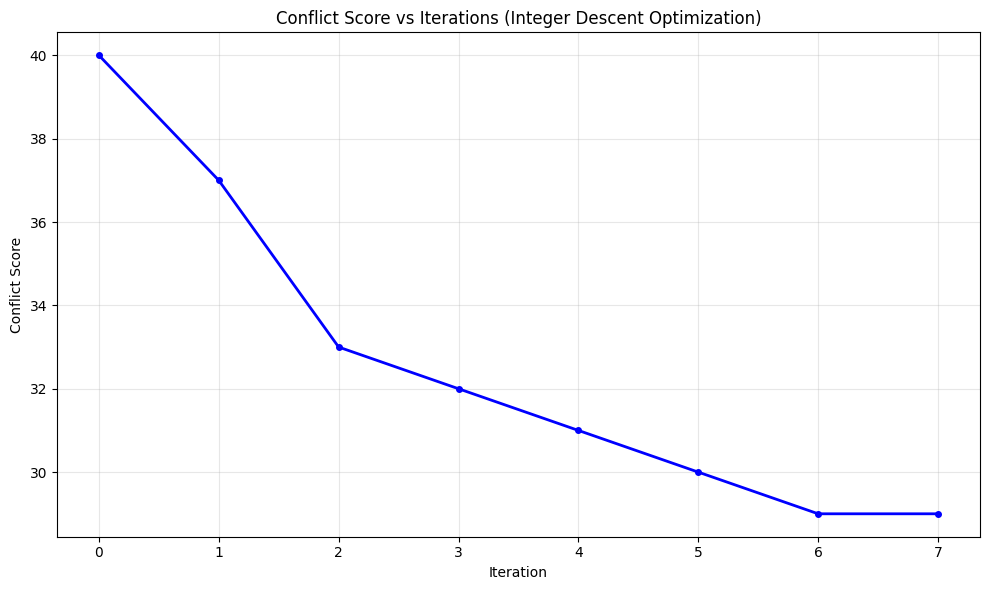


Optimization completed successfully!
Converged in 7 iterations


In [10]:
import numpy as np
import matplotlib.pyplot as plt
from typing import List, Tuple, Set
import copy

# Configuration (grid + chips)
GRID_WIDTH = 10
GRID_HEIGHT = 10

# chips as dicts: {'id': int, 'width': int, 'height': int, 'x': int, 'y': int}
chips: List[dict] = []

# connections as list of (id1, id2)
connections: List[Tuple[int, int]] = []

# Helper: add chips & connections
def add_chip(chip_id: int, width: int, height: int, x: int, y: int):
    chips.append({'id': chip_id, 'width': width, 'height': height, 'x': x, 'y': y})

def add_connection(c1: int, c2: int):
    connections.append((c1, c2))

def get_chip_by_id(chip_id: int) -> dict:
    for ch in chips:
        if ch['id'] == chip_id:
            return ch
    raise ValueError(f"Chip {chip_id} not found")

# Metrics: wiring cost & overlap
def calculate_wiring_cost(chip1: dict, chip2: dict) -> float:
    xi, wi = chip1['x'], chip1['width']
    xj, wj = chip2['x'], chip2['width']
    yi, yj = chip1['y'], chip2['y']

    # horizontal gap (0 if overlapping or abutting)
    horizontal_cost = max(0, xj - (xi + wi), xi - (xj + wj))
    vertical_cost = abs(yi - yj)
    return horizontal_cost + vertical_cost

def get_occupied_cells(chip: dict) -> Set[Tuple[int,int]]:
    cells = set()
    for dx in range(chip['width']):
        for dy in range(chip['height']):
            cells.add((chip['x'] + dx, chip['y'] + dy))
    return cells

def calculate_overlap_blocks(chip1: dict, chip2: dict) -> int:
    cells1 = get_occupied_cells(chip1)
    cells2 = get_occupied_cells(chip2)
    return len(cells1.intersection(cells2))

def calculate_total_conflict_score() -> float:
    total_score = 0.0
    # wiring costs (only for connected pairs)
    for c1, c2 in connections:
        ch1 = get_chip_by_id(c1)
        ch2 = get_chip_by_id(c2)
        total_score += calculate_wiring_cost(ch1, ch2)
    # overlaps (every unordered pair)
    for i in range(len(chips)):
        for j in range(i+1, len(chips)):
            total_score += calculate_overlap_blocks(chips[i], chips[j])
    return total_score

# Detailed breakdown (for final)
def calculate_detailed_conflict_breakdown() -> dict:
    breakdown = {
        'wiring_costs': {},
        'overlap_costs': {},
        'total_wiring': 0.0,
        'total_overlap': 0.0,
        'total_score': 0.0
    }
    for a,b in connections:
        ch1 = get_chip_by_id(a)
        ch2 = get_chip_by_id(b)
        cost = calculate_wiring_cost(ch1, ch2)
        key = (min(a,b), max(a,b))
        breakdown['wiring_costs'][key] = cost
        breakdown['total_wiring'] += cost

    for i in range(len(chips)):
        for j in range(i+1, len(chips)):
            ch1 = chips[i]
            ch2 = chips[j]
            blocks = calculate_overlap_blocks(ch1, ch2)
            if blocks > 0:
                key = (min(ch1['id'], ch2['id']), max(ch1['id'], ch2['id']))
                breakdown['overlap_costs'][key] = blocks
                breakdown['total_overlap'] += blocks

    breakdown['total_score'] = breakdown['total_wiring'] + breakdown['total_overlap']
    return breakdown

def print_detailed_conflict_breakdown():
    breakdown = calculate_detailed_conflict_breakdown()
    print(f"\nFinal Discrete Conflict Score: {int(breakdown['total_score'])}")
    print("\nDetailed Conflict Breakdown:")
    print("\tWiring Costs:")
    for (a,b), cost in sorted(breakdown['wiring_costs'].items()):
        if cost > 0:
            print(f"\t \tChips {a}-{b}: {int(cost)}")
    if breakdown['overlap_costs']:
        print("\tOverlap Costs:")
        for (a,b), blocks in sorted(breakdown['overlap_costs'].items()):
            print(f"\t \tChips {a}-{b}: {blocks} blocks")
    else:
        print("\tOverlap Costs:")
        print("\t  No overlaps found!")
    print(f"\nTotal Wiring Cost: {int(breakdown['total_wiring'])}")
    print(f"Total Overlap Cost: {int(breakdown['total_overlap'])}")
    print(f"Total Conflict Score: {int(breakdown['total_score'])}")

def create_grid_visualization() -> np.ndarray:
    grid = np.full((GRID_HEIGHT, GRID_WIDTH), "0", dtype=object)
    for ch in chips:
        for dx in range(ch['width']):
            for dy in range(ch['height']):
                gx = ch['x'] + dx
                gy = ch['y'] + dy
                if 0 <= gx < GRID_WIDTH and 0 <= gy < GRID_HEIGHT:
                    if grid[gy, gx] == "0":
                        grid[gy, gx] = str(ch['id'])
                    else:
                        existing = grid[gy, gx]
                        if "/" not in existing:
                            grid[gy, gx] = f"{existing}/{ch['id']}"
                        else:
                            grid[gy, gx] = f"{existing}/{ch['id']}"
    return grid

def print_grid():
    grid = create_grid_visualization()
    print("\nGrid Visualization (rows y = {} → 0):".format(GRID_HEIGHT-1))
    print("=" * (GRID_WIDTH * 4 + 5))
    for row in reversed(range(GRID_HEIGHT)):
        row_str = f"y={row:>2} |"
        for col in range(GRID_WIDTH):
            cell_content = str(grid[row, col])
            row_str += f" {cell_content:>3}"
        print(row_str)
    print("     " + "".join([f" {i:>3}" for i in range(GRID_WIDTH)]))
    print("     " + "   x=" + "".join([f"{i:>3}" for i in range(GRID_WIDTH)]))

def print_chip_positions(title="Chip Positions"):
    print(f"\n{title}:")
    print("Chip ID | Position (x,y) | Size (w×h)")
    print("-" * 40)
    for ch in sorted(chips, key=lambda c: c['id']):
        print(f"   c{ch['id']}   |    ({ch['x']},{ch['y']})     |   {ch['width']}×{ch['height']}")

def plot_conflict_history(history: List[float]):
    plt.figure(figsize=(10, 6))
    plt.plot(range(len(history)), history, 'b-o', linewidth=2, markersize=4)
    plt.xlabel('Iteration')
    plt.ylabel('Conflict Score')
    plt.title('Conflict Score vs Iterations (Integer Descent Optimization)')
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

# Integer-descent optimizer (procedural)
def is_valid_position(chip: dict, new_x: int) -> bool:
    return 0 <= new_x and new_x + chip['width'] <= GRID_WIDTH

def get_neighbors(chip: dict) -> List[int]:
    neighbors = []
    if is_valid_position(chip, chip['x'] - 1):
        neighbors.append(chip['x'] - 1)
    if is_valid_position(chip, chip['x'] + 1):
        neighbors.append(chip['x'] + 1)
    return neighbors

def integer_descent_step() -> bool:
    current_score = calculate_total_conflict_score()
    best_improvement = None
    best_chip_index = None
    best_new_x = None

    for idx, chip in enumerate(chips):
        for new_x in get_neighbors(chip):
            old_x = chip['x']
            chip['x'] = new_x
            new_score = calculate_total_conflict_score()
            improvement = current_score - new_score
            if improvement > 0 and (best_improvement is None or improvement > best_improvement):
                best_improvement = improvement
                best_chip_index = idx
                best_new_x = new_x
            # revert
            chip['x'] = old_x

    if best_improvement is not None and best_chip_index is not None:
        chips[best_chip_index]['x'] = best_new_x
        return True
    return False

def optimize(max_iterations: int = 100) -> List[float]:
    conflict_history: List[float] = []
    for iteration in range(max_iterations):
        current_score = calculate_total_conflict_score()
        conflict_history.append(current_score)
        print(f"Iteration {iteration}: Conflict Score = {current_score}")
        improved = integer_descent_step()
        if not improved:
            print(f"Converged after {iteration + 1} iterations")
            break
    # append final score
    final_score = calculate_total_conflict_score()
    conflict_history.append(final_score)
    return conflict_history

# Main (create chips, run optimizer)
def main():
    # populate chips (same input as your OOP example)
    chip_data = [
        (1, 2, 4, 0, 0),
        (2, 2, 5, 1, 1),
        (3, 1, 3, 1, 0),
        (4, 2, 5, 2, 4),
        (5, 2, 4, 3, 3),
        (6, 1, 4, 2, 2),
        (7, 2, 5, 0, 5),
        (8, 1, 3, 4, 6),
    ]
    for chip_id, width, height, x, y in chip_data:
        add_chip(chip_id, width, height, x, y)

    conns = [(1, 2), (2, 6), (2, 3), (3, 5), (4, 5), (5, 6), (1, 6), (7, 4), (7, 2), (8, 5)]
    for a,b in conns:
        add_connection(a, b)

    print("CHIP PLACEMENT OPTIMIZATION USING INTEGER DESCENT")
    print("=" * 60)

    print("\nINITIAL STATE:")
    initial_score = calculate_total_conflict_score()
    print(f"Initial Conflict Score: {initial_score}")
    print_chip_positions("Initial Chip Positions")
    print("\nInitial Grid State:")
    print_grid()

    print("\n" + "=" * 60)
    print("RUNNING INTEGER DESCENT OPTIMIZATION...")
    print("=" * 60)

    history = optimize(max_iterations=100)

    print("\n" + "=" * 60)
    print("FINAL RESULTS:")
    print("=" * 60)

    final_score = calculate_total_conflict_score()
    print(f"\nFinal Conflict Score: {final_score}")
    print(f"Total Improvement: {initial_score - final_score}")

    print_detailed_conflict_breakdown()
    print_chip_positions("Final Chip Positions")

    print("\nFinal Grid State:")
    print_grid()

    plot_conflict_history(history)

    print("\nOptimization completed successfully!")
    print(f"Converged in {len(history) - 1} iterations")

if __name__ == "__main__":
    main()
